# Friend of the Pod? 
---
---

##  Problem Statement
It’s very common in the United States, especially in political media, to hear Liberals and the Left referred to interchangeably, but is this really the case? In a sample poll, 100% of my uncles were either unable to tell them apart, or at least considered it a distinction without a difference

But, with a little web scraping and some natural language processing, can we prove that it’s not very hard to tell the Liberals apart from the Left? 


## Hypothesis?
Are Liberals and the Left indistinguishable from one another? 

## The Dataset
There aren't entirely analagous Liberal and Left subreddits, but I believe I chose two that illustrate the differences well. I knew early on that I wanted Pod Save America's r\/FriendsoftheePod for the Liberal subreddit, because it's bit more than *just* a podcast. Made up of former Obama comms department staffers, Pod Save America is the flagiship podcast  of Crooked Media, practically a clearing house for the establishment of the Democratic Party and a seeminly essential waypoint for both veteran and up-and-coming Liberal political figures. But, there's not really a leftwing media property equivalent. Even if Reddit hadn't axed r\/ChapoTrapHouse last year, they're just wholly different in both scope and fuction; one can land interviews with Barrack Obama or Joe Biden, the other's big gets are Adam McKay and Marianne Williamson. It's really kind of difficult to imagine what a Left-wing Pod Save America would even *be*, so instead I chose r\/IWW, the Industrial Workers of the World subreddit for the Left alternative. Pod Save America makes sense in the way that Liberals are often highly concerned with being well represented by those in power, while the IWW makes sense as Leftists are concered with building a base of politcial power. Difficult as I think it is to imagine a Lefty-Pod Save America, I can imagine that a Liberal-IWW would come to resemble Pod Save America more and more over time in its functions and goals 

---
### Import and read in
---

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import time
from datetime import datetime
from pmaw import PushshiftAPI
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.svm import SVC
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, accuracy_score, plot_roc_curve, roc_auc_score, f1_score, recall_score, precision_score

sns.set(style="ticks", context="talk")
plt.style.use("fivethirtyeight")

In [2]:
url = 'https://api.pushshift.io/reddit/search/submission'
subred1 = 'FriendsofthePod'
subred2 = 'IWW'
subred3 = 'communism'
subred4 = 'InformedTankie'

iters = 60000 # number of posts to be scrapped from each subreddit
# weights are used to make a more balanced dataset 
weight1 = 1
weight2 = 1/5
# weight3 = 1/30
# weight4 = 1/20

---
### PushShift API
---

In [3]:
api = PushshiftAPI()

In [4]:
df = pd.DataFrame() 
# weights = [weight1, weight2, weight3, weight4]
weights = [weight1, weight2]
# for idx, i in enumerate([subred1, subred2, subred3, subred4]):
for idx, i in enumerate([subred1, subred2]):
    posts = api.search_submissions(subreddit=i, limit=(int(iters*weights[idx])), safe_exit=True)
    post_list = [post for post in posts]
    df_i = pd.DataFrame(post_list)
    df_i = df_i[['subreddit', 'title', 'selftext']]
    df = pd.concat([df, df_i])

Response cache key: c989d76faebcd54cbc0a65d77c0404e1
52717 result(s) not found in Pushshift
Total:: Success Rate: 100.00% - Requests: 27 - Batches: 3 - Items Remaining: 5081
Total:: Success Rate: 100.00% - Requests: 52 - Batches: 6 - Items Remaining: 2985
Total:: Success Rate: 100.00% - Requests: 73 - Batches: 9 - Items Remaining: 1324
5 result(s) not found in Pushshift
Total:: Success Rate: 100.00% - Requests: 89 - Batches: 11 - Items Remaining: 205
Total:: Success Rate: 100.00% - Requests: 99 - Batches: 12 - Items Remaining: 0
Response cache key: a5db7531b5c56c99c9eb8da816cef531
4308 result(s) not found in Pushshift
Total:: Success Rate: 100.00% - Requests: 23 - Batches: 3 - Items Remaining: 5855
Total:: Success Rate: 100.00% - Requests: 46 - Batches: 6 - Items Remaining: 4027
Total:: Success Rate: 100.00% - Requests: 60 - Batches: 8 - Items Remaining: 3019
5 result(s) not found in Pushshift
Total:: Success Rate: 100.00% - Requests: 70 - Batches: 9 - Items Remaining: 2444
Total:: Suc

--- 
### Data Cleaning
---
Removing any blank, self-referencing, or deleted posts 

In [5]:
for i in ['', ' ', '[removed]', '[deleted]', 'deleted', 'blank', 'Title', 'title', 'NaN', 'nan']:
    df = df[(df.selftext != i)]
df = df[(df.selftext.notnull())]

In [6]:
df.head()

,subreddit,title,selftext
4,FriendsofthePod,What A Day: Garbage Parson by Sarah Lazarus &a...,"*""They have a picture and it says 'what’s that..."
6,FriendsofthePod,Recently recommended books?,There was a PSA at some point in the last coup...
10,FriendsofthePod,Inside jokes? Would love explanations,I'm a new friend of the pod (why did I miss ou...
14,FriendsofthePod,"What A Day: Oregon, Trailed by Sarah Lazarus, ...","*""Donald Trump as President has had an impact ..."
16,FriendsofthePod,LOLI episode with The Crown on the Rant Wheel?,"Very specific, but does anyone remember which ..."


In [7]:
df.selftext.isnull().sum()

0

In [8]:
df.subreddit.value_counts()

FriendsofthePod    1783
IWW                1577
Name: subreddit, dtype: int64

In [9]:
df.selftext.nunique()

3099

In [10]:
df.selftext

4       *"They have a picture and it says 'what’s that...
6       There was a PSA at some point in the last coup...
10      I'm a new friend of the pod (why did I miss ou...
14      *"Donald Trump as President has had an impact ...
16      Very specific, but does anyone remember which ...
                              ...                        
7662    I nominate liko, as he's the most active and v...
7671    Repost:\n\nThe IWW is coming to the US Social ...
7672    The second page is the hardest hitting part, a...
7675    FW's and visitors. I am fairly new to the IWW ...
7681    FW's, This subreddit is on the verge of becomi...
Name: selftext, Length: 3360, dtype: object

---
### Export
---

In [11]:
df.to_csv("./data/scrapped_subreddits.csv")

---
### EDA 
---

#### Word Frequency w/ CountVectorizor

In [12]:
from sklearn.feature_extraction.text import CountVectorizer
X = df['selftext'].copy()
cvec = CountVectorizer(min_df=2, max_df=0.3, ngram_range= (1,1), stop_words='english')
cvec.fit(X)
X = cvec.transform(X)
X_df = pd.DataFrame(X.todense(), columns=cvec.get_feature_names())
X_df.head()
# cvec.get_feature_names()[:20]
X_df.sum().sort_values(ascending=False).head(40)

com                         20376
www                         14259
trump                       13157
h_sid                        8969
59d5592b0a21f78c3a091e84     8882
utm_source                   6172
utm_medium                   6159
utm_campaign                 6116
email                        5974
html                         5858
hive                         5093
twitter                      4878
2020                         4108
politics                     3979
news                         3974
status                       3520
house                        3428
2019                         3216
2018                         3040
president                    2925
coronavirus                  2400
nytimes                      2250
crooked                      2211
white                        2164
state                        2095
cnn                          2018
democrats                    1904
time                         1859
election                     1821
washingtonpost

Making a list of extra stop words that mostly seem to be fragments from the vectorizing process breaking apart URLs

In [13]:
extra_stop_words = ['amp', 'com', 'www', 'http', 'https' 'utm_source', 'utm_medium', 'utm_campaign', 
               'html', 'h_sid', '59d5592b0a21f78c3a091e84', 'status', 'org', 'index', ]

Text(0.5, 0, 'Word Frequency')

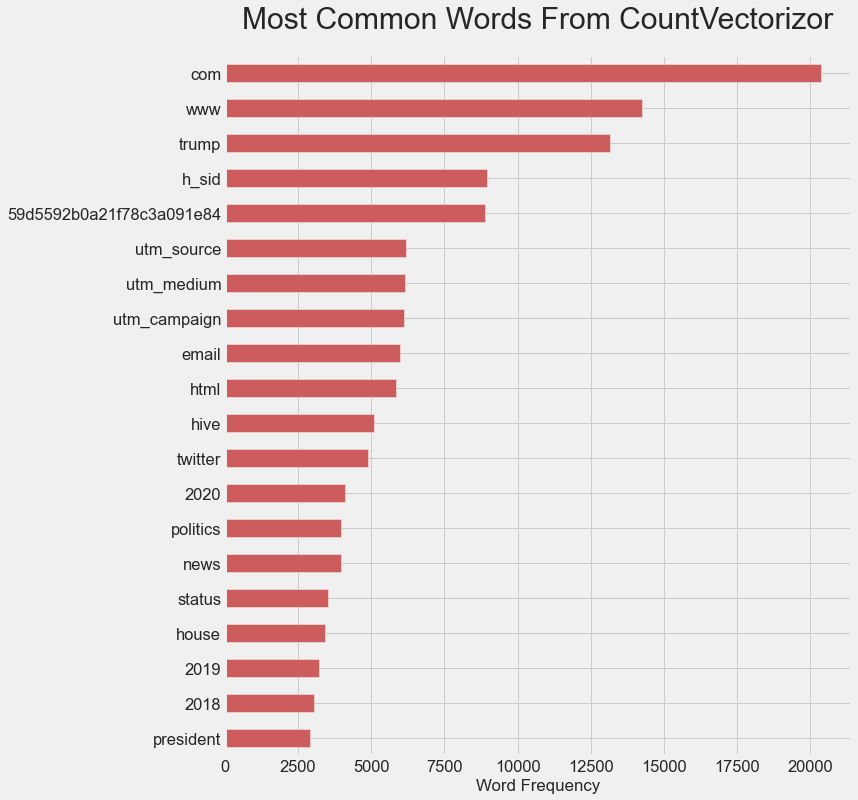

In [14]:
plt.figure(figsize=(10, 12))
X_df.sum().sort_values(ascending=False).head(20).sort_values(ascending=True).plot(kind='barh', color='indianred')
plt.title('Most Common Words From CountVectorizor', fontsize=30, y=1.03)
plt.xlabel('Word Frequency')

Many of these were the kind of politically relevent we would hope to see at the top of the list, but some of the terms were clearly collateral leftover from the tokenizing process, so the following list was isolated as extra stop words that would be removed in the tokenizer-Lemmatizer function 

#### Sentiment Analysis

In [15]:
from transformers import pipeline

/Users/rylandmatthews/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/torchaudio/backend/utils.py:53: UserWarning: "sox" backend is being deprecated. The default backend will be changed to "sox_io" backend in 0.8.0 and "sox" backend will be removed in 0.9.0. Please migrate to "sox_io" backend. Please refer to https://github.com/pytorch/audio/issues/903 for the detail.
  warnings.warn(


In [16]:
sent = pipeline('sentiment-analysis')

In [18]:
# sentiment analysis as per GA DSI Week 5 lesson: Word Vectors
# using the first thousand characters in each selftext string
df['sentiment'] = df['selftext'].astype(str).map(lambda x: sent(x[:512])[0]['label'])

In [19]:
df['sentiment'] = df['sentiment'].map({'POSITIVE': 1, 'NEGATIVE': -1})
df.groupby('subreddit')['sentiment'].describe().T

subreddit,FriendsofthePod,IWW
count,1783.000000,1577.000000
mean,-0.553561,-0.584020
std,0.833042,0.811997
min,-1.000000,-1.000000
25%,-1.000000,-1.000000
50%,-1.000000,-1.000000
75%,-1.000000,-1.000000
max,1.000000,1.000000


In [20]:
df.groupby('subreddit')['sentiment'].value_counts()

subreddit        sentiment
FriendsofthePod  -1           1385
                  1            398
IWW              -1           1249
                  1            328
Name: sentiment, dtype: int64

In [21]:
df.groupby('subreddit')['sentiment'].mean()

subreddit
FriendsofthePod   -0.553561
IWW               -0.584020
Name: sentiment, dtype: float64

Text(0.5, 1.04, 'Sentiment Analysis Shows Most Posts Express Mostly Negative Sentiment')

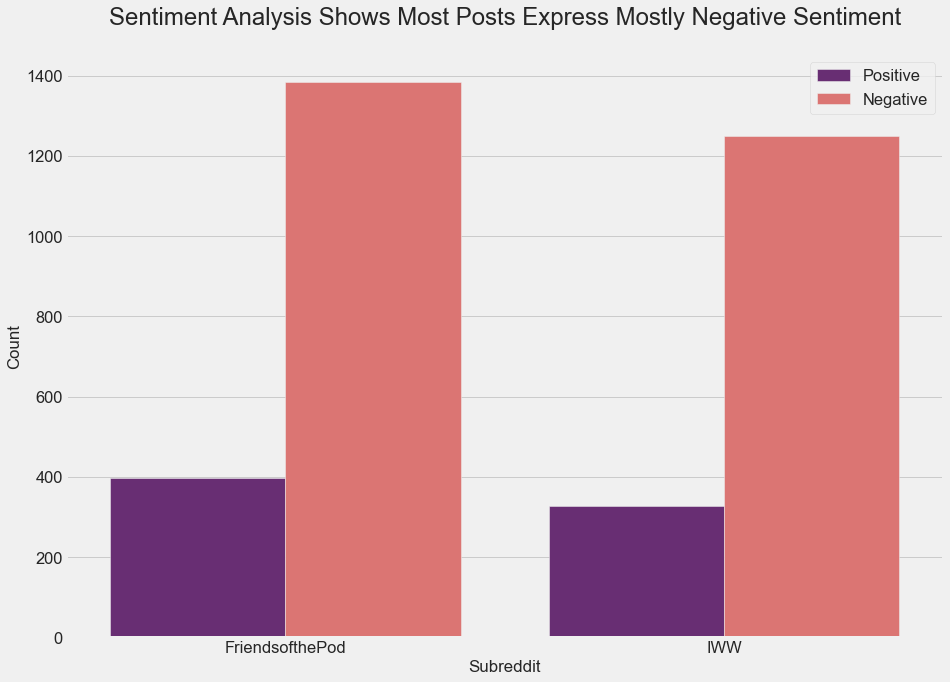

In [22]:
plt.figure(figsize=(14, 10))
sns.countplot(data=df, x='subreddit', hue='sentiment', hue_order=[1, -1], 
              palette='magma', saturation=0.7)
plt.legend(['Positive', 'Negative'])
plt.xlabel('Subreddit')
plt.ylabel('Count')
plt.title('Sentiment Analysis Shows Most Posts Express Mostly Negative Sentiment',
         fontsize=24, y=1.04)

As one might expect, most political posts tend to be based around pretty negative sentiment, and since they seemed to follow a pretty similar pattern of mostly negative sentiment, decided not to use this in the model

--- 
### Feature Engineering
---

#### Tokenizing & Lemmatizing
Using a Regex Tokenizer to split the words out from each post then Lemmatize them.
Then our extra stop words are removed before being joined back into a string 

In [23]:
file = "./data/scrapped_subreddits.csv"
df = pd.read_csv(file)

# letting it read in the Unnamed column then dropping it fixes any indexing weirdness from the concatination process 
df.drop(columns='Unnamed: 0', inplace=True)

In [24]:
tokenizer = RegexpTokenizer(r"\w+")
lemmatizer = WordNetLemmatizer()
def toklem(string):
    """
    This function 
    """
    tokens = tokenizer.tokenize(string.lower())
    lemmed = [lemmatizer.lemmatize(token) for token in tokens]
    # filtering out custom words as per https://www.dezyre.com/recipes/add-custom-stopwords-and-then-remove-them-from-text
    filtered = [words for words in lemmed if not words in extra_stop_words]
    separator = ' '
    return separator.join(filtered)
df['selftext'] = df['selftext'].astype(str).map(toklem)
df['title'] = df['title'].astype(str).map(toklem)
# remobing any null selftext entries in case any were created in the Tokenizer-Lemmatizer process
df = df[(df.selftext.notnull())]

#### Verbosity Metrics
Exploring if metrics about the verbosity for any of the subreddits was notably different than the others 

In [25]:
df['post_length'] = df['selftext'].astype(str).map(len)
df.groupby('subreddit')['post_length'].describe().T

subreddit,FriendsofthePod,IWW
count,1783.000000,1577.000000
mean,4392.531688,763.767914
std,5221.051409,1673.293293
min,0.000000,2.000000
25%,192.000000,195.000000
50%,571.000000,279.000000
75%,10351.000000,645.000000
max,19298.000000,19425.000000


Also checking the word count in each post

In [26]:
df['word_count'] = df['selftext'].astype(str).map(str.split).map(len)
df = df[df['word_count'] != 0]
df.groupby('subreddit')['word_count'].describe().T

subreddit,FriendsofthePod,IWW
count,1782.000000,1577.000000
mean,726.971942,137.717185
std,851.083741,289.986322
min,1.000000,1.000000
25%,38.000000,34.000000
50%,110.500000,53.000000
75%,1687.500000,125.000000
max,3001.000000,3274.000000


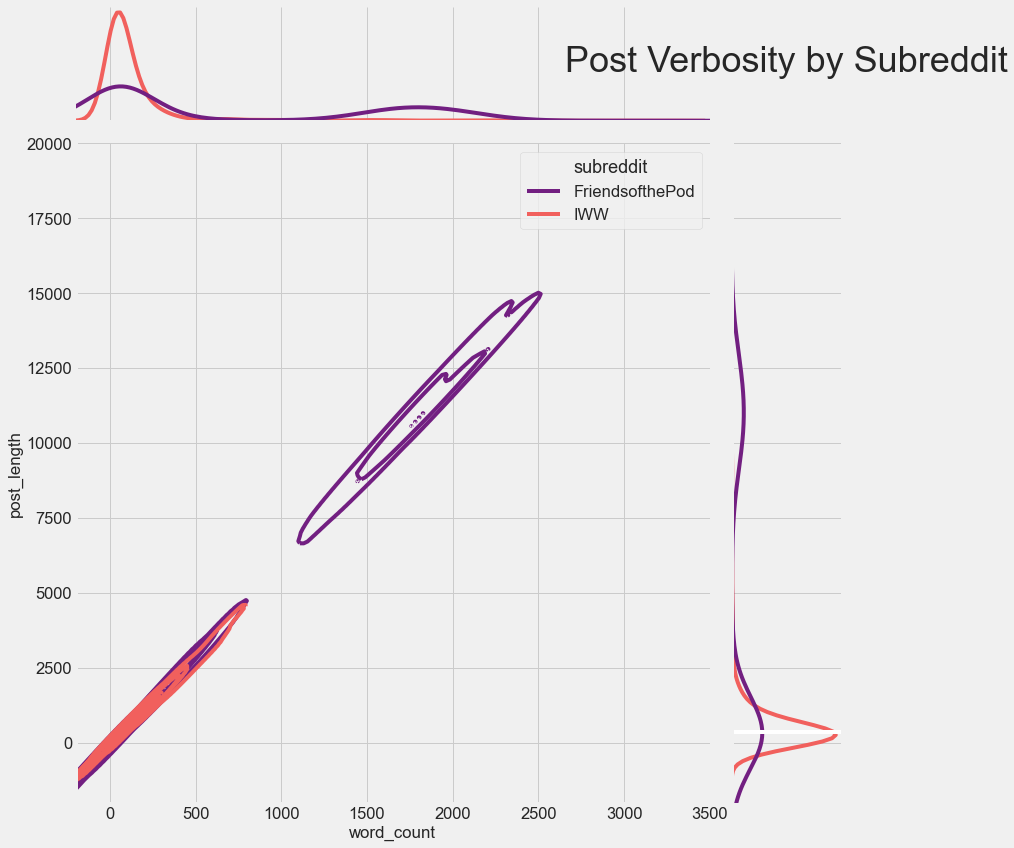

In [27]:
sns.jointplot(data=df, 
           x='word_count', 
           y='post_length',
           hue='subreddit',
           kind='kde', height=12, palette='magma', xlim=[-200, 3500], ylim=[-2000,20000])
plt.axhline(df.post_length.median(), color='white')
plt.xlabel('Word Count')
plt.ylabel('Post Length')
plt.title('Post Verbosity by Subreddit', fontsize=36, y=1.1);

FriendsofthePod clearly has a significant number of longer posts, and I had assumed that this would be useful if passed into the pipeline with ColumnTransformer, but doing so only made the model's predictions worse and ended up not using it

#### Mapping our target classification 
The Liberal subreddit will be coded as *1* while the Left subreddits will be coded as *0* 

In [28]:
df['subreddit'] = df['subreddit'].map({subred1: 1, subred2: 0, subred3: 0, subred4: 0})

---
---
---

In [29]:
# Shuffling the dataset... just because 
# df = df.sample(n=df.shape[0], replace=False, random_state=404)
# df.shape

#### Baseline Accuracy
Checking final distribution and one last look at the DataFrame

In [30]:
df['subreddit'].value_counts(normalize=True)

1    0.530515
0    0.469485
Name: subreddit, dtype: float64

In [31]:
df

,subreddit,title,selftext,post_length,word_count
0,1,what a day garbage parson by sarah lazarus cro...,they have a picture and it say what s that and...,11832,1986
1,1,recently recommended book,there wa a psa at some point in the last coupl...,233,46
2,1,inside joke would love explanation,i m a new friend of the pod why did i miss out...,798,171
3,1,what a day oregon trailed by sarah lazarus bri...,donald trump a president ha had an impact on r...,10911,1868
4,1,loli episode with the crown on the rant wheel,very specific but doe anyone remember which re...,126,24
...,...,...,...,...,...
3355,0,nomination for iww subreddit representative to...,i nominate liko a he s the most active and vis...,71,14
3356,0,the iww is coming to the u social forum,repost the iww is coming to the u social forum...,3143,522
3357,0,5 creepy way video game are trying to get you ...,the second page is the hardest hitting part an...,424,78
3358,0,iama wobbly a of early this year attached to a...,fw s and visitor i am fairly new to the iww a ...,717,128


In [32]:
df.isnull().sum()

subreddit      0
title          0
selftext       0
post_length    0
word_count     0
dtype: int64

---
### Modeling
---

In [33]:
X = df['selftext'].copy()
Z = df['title'].copy()
y = df['subreddit'].copy()

In [34]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
X_train.shape[0] == y_train.shape[0], X_test.shape[0] == y_test.shape[0]

(True, True)

In [35]:
y_test.shape

(1008,)

In [36]:
pipe = Pipeline([
    ("tvec", TfidfVectorizer(stop_words='english',
                            min_df=3,
                            max_df=0.6,
                            )),
#     ("sc", StandardScaler(with_mean=False)),
    ("vc", VotingClassifier(estimators=[
                                        ("lr", LogisticRegression(solver='liblinear')),
                                        ('svc', SVC(degree=2, kernel='rbf', random_state=42,
                                                    probability=True)),
                                        ("rfc", RandomForestClassifier(random_state=42,
                                                                       max_depth=100,
                                                                       min_samples_split=2,
                                                                       min_samples_leaf=3,))],
                            weights=[1, 2, 2], 
                            voting='soft'))
                                        ])

# weights = [[1, 1, 1], [1, 2, 1], [1, 2, 2], [1, 2, 3], 
#            [2, 1, 1], [2, 2, 1], [3, 2, 1], [2, 3, 1]]

pipe_params = {
#     'vc__weights': weights,
    'tvec__max_features': [7500],
    'tvec__ngram_range': [(1, 1)],
#     'vc__voting': ['hard', 'soft'],
    'vc__rfc__max_depth': [100],
    'vc__lr__penalty': ['l2'],
    'vc__svc__max_iter': [1500],
    'vc__svc__C': [20],
    'vc__rfc__n_estimators': [100]
}

vc_gridsearch = GridSearchCV(pipe,
                            param_grid=pipe_params,
                            cv=30,
                            verbose=1,
                            n_jobs=-1)

In [37]:
# pipe.get_params()

In [38]:
%%time
vc_gridsearch.fit(X_train, y_train)
print("Best Score:", vc_gridsearch.best_score_)
print("Best Estimator:", vc_gridsearch.best_estimator_)
print("Best Parameters:", vc_gridsearch.best_params_)

Fitting 30 folds for each of 1 candidates, totalling 30 fits


/Users/rylandmatthews/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


Best Score: 0.9540192578167261
Best Estimator: Pipeline(steps=[('tvec',
                 TfidfVectorizer(max_df=0.6, max_features=7500, min_df=3,
                                 stop_words='english')),
                ('vc',
                 VotingClassifier(estimators=[('lr',
                                               LogisticRegression(solver='liblinear')),
                                              ('svc',
                                               SVC(C=20, degree=2,
                                                   max_iter=1500,
                                                   probability=True,
                                                   random_state=42)),
                                              ('rfc',
                                               RandomForestClassifier(max_depth=100,
                                                                      min_samples_leaf=3,
                                                                      random_s

In [42]:
preds = vc_gridsearch.predict(X_test)
print('Precision:', precision_score(y_test, preds))
print('Recall:   ', recall_score(y_test, preds))
print('F1:   ', f1_score(y_test, preds))

Precision: 0.9420289855072463
Recall:    0.9719626168224299
F1:    0.9567617295308187


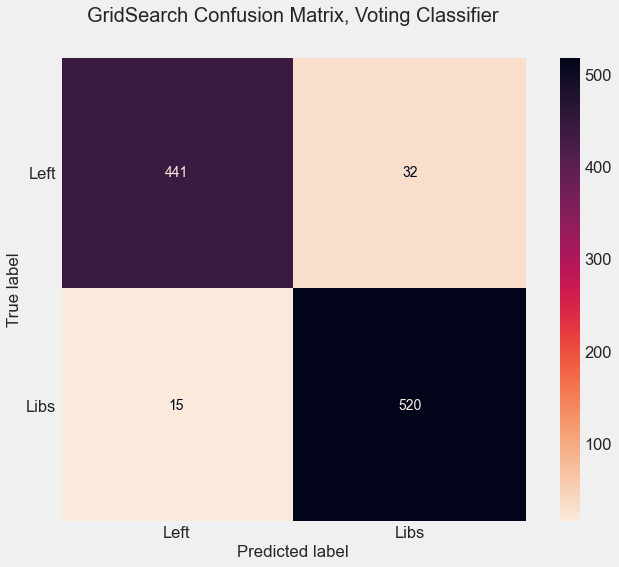

In [43]:
# changed figsize as per https://panjeh.medium.com/figure-size-plot-confusion-matrix-in-scikit-learn-2c66f3a69d81
fig, ax = plt.subplots(figsize=(10, 8))
plot_confusion_matrix(vc_gridsearch, X_test, y_test, 
                      display_labels=['Left', 'Libs'], 
                      normalize=None, 
#                       normalize='all',
                      cmap="rocket_r", ax=ax)
plt.grid(False)
plt.title("GridSearch Confusion Matrix, Voting Classifier", fontsize=20, y=1.06);

This model had the best balance of precision and recall, as seen in the f1 score, while maintaining high accuracy 

## Conclusion
The hypothesis, that it is too difficult to tell the Liberals and the Left apart, seems to be pretty soundly disproven. This was done without relying on any metrics about verbosity or sentiment, or leaning on overabundant pseudo-words left over from the tokenizing process. This shows that Liberals and Leftists really do just talk about very different, distinct things  

---
---

Included below are each of the classifiers from the primary model run with the same hyper-parameters

In [44]:
def single_classifier(classifier_name, classifier):
    """
    This function 
    """
    test_pipe = Pipeline([
        ("tvec", TfidfVectorizer(stop_words='english', max_features=7000, min_df=3, 
                             max_df=0.6, ngram_range=(1, 2),)),
        classifier])
    
    test_params = {}
    
    test_grid = GridSearchCV(test_pipe,
                        param_grid=test_params,
                        cv=30,
                        verbose=1,
                        n_jobs=-1)
    
    test_grid.fit(X_train, y_train)
    
    preds = test_grid.predict(X_test)
    
    print(classifier_name)
    print("Train Score:", test_grid.score(X_train, y_train))
    print("Test Score:", test_grid.score(X_test, y_test))
    print()
    rmse = mean_squared_error(y_test, preds, squared=False)
    print('Accuracy: ', accuracy_score(y_test, preds))
    print('Precision:', precision_score(y_test, preds))
    print('Recall:   ', recall_score(y_test, preds))
    print('F1:   ', f1_score(y_test, preds))
    
    fig, ax = plt.subplots(figsize=(10, 8))
    plot_confusion_matrix(test_grid, X_test, y_test, display_labels=['Left', 'Libs'], 
                          normalize=None, cmap="rocket_r", ax=ax)
    plt.grid(False)
    plt.title(f"GridSearch Confusion Matrix, {classifier_name}", fontsize=20, y=1.06);

Fitting 30 folds for each of 1 candidates, totalling 30 fits
Logistic Regression
Train Score: 0.9863887707358571
Test Score: 0.9424603174603174

Accuracy:  0.9424603174603174
Precision: 0.9312839059674503
Recall:    0.9626168224299065
F1:    0.9466911764705882


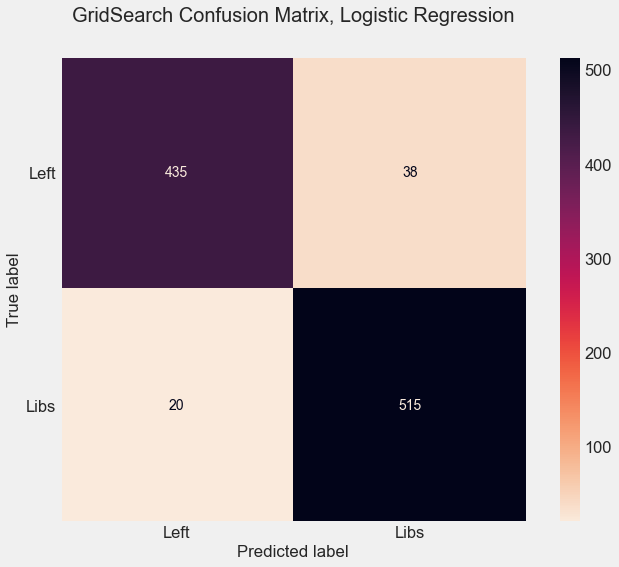

In [45]:
single_classifier('Logistic Regression', ("lr", LogisticRegression(solver='liblinear')))

Fitting 30 folds for each of 1 candidates, totalling 30 fits


/Users/rylandmatthews/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


Support Vector Classifier
Train Score: 0.9961718417694598
Test Score: 0.9444444444444444

Accuracy:  0.9444444444444444
Precision: 0.9315315315315316
Recall:    0.9663551401869159
F1:    0.9486238532110092


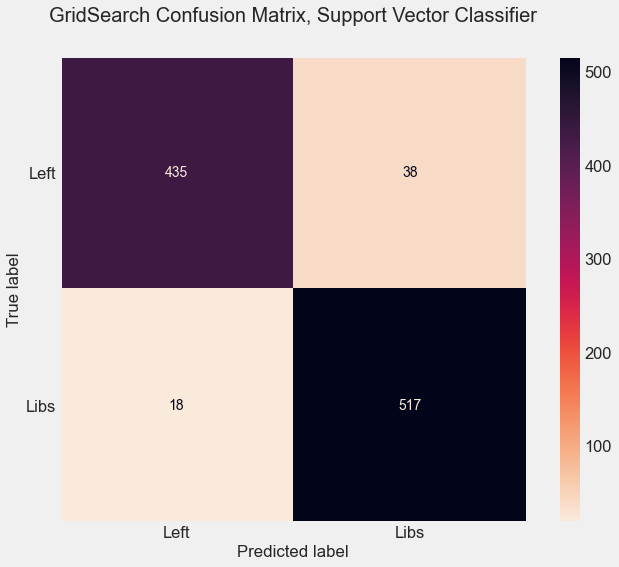

In [46]:
single_classifier('Support Vector Classifier', 
                              ('svc', SVC(degree=2, kernel='rbf', random_state=42, 
                                          probability=True, max_iter=1000)))

Fitting 30 folds for each of 1 candidates, totalling 30 fits
Random Forest Classifier
Train Score: 0.9698000850701829
Test Score: 0.9325396825396826

Accuracy:  0.9325396825396826
Precision: 0.9118165784832452
Recall:    0.9663551401869159
F1:    0.9382940108892921


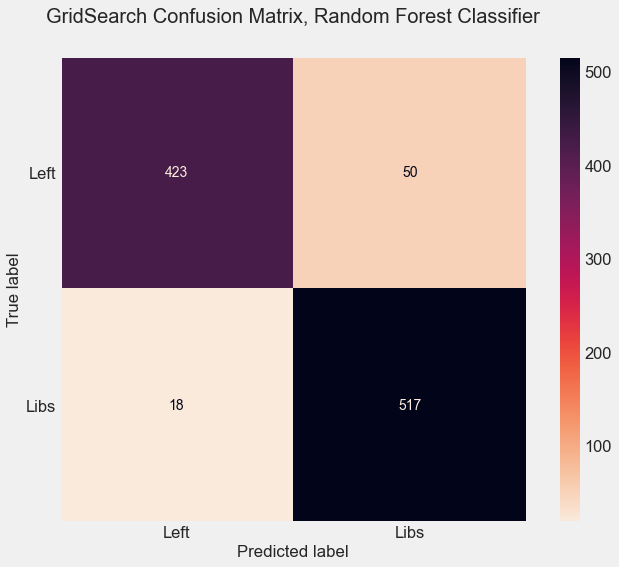

In [47]:
single_classifier('Random Forest Classifier', 
                             ("rfc", RandomForestClassifier(random_state=42, max_depth=100, 
                                                            min_samples_split=2, n_estimators=100, 
                                                            min_samples_leaf=3,)))